# paddleOCR — Evaluation & Debug Notebook  
**Author:** Manel

## Purpose
Evaluate paddleOCR on document pages (PDF → images) with:
- Visual inspection (original + preprocessed)
- OCR text preview
- Word-level bounding boxes and confidence
- Quick sweeps over preprocessing + `psm` layouts


#### Imports

In [3]:
import os
from pathlib import Path
from typing import List, Dict, Any
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from paddleocr import PaddleOCR
import cv2
from IPython.display import display
import pandas as pd
from pytesseract import Output
import numpy as np
from PIL import Image, ImageOps, ImageEnhance

#### Paths

In [ ]:
BASE_DIR = Path.cwd()  
DATA_DIR = BASE_DIR.parent / "data" / "images"

#### Display Helpers

In [3]:
def show(img, title=None, figsize=(10, 12)):
    if isinstance(img, (str, Path)):
        img = Image.open(img)
    plt.figure(figsize=figsize)
    cmap = "gray" if img.mode in ["L", "1"] else None
    plt.imshow(img, cmap=cmap)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

def crop(img, x1, y1, x2, y2):
    if isinstance(img, (str, Path)):
        img = Image.open(img)
    return img.crop((x1, y1, x2, y2))

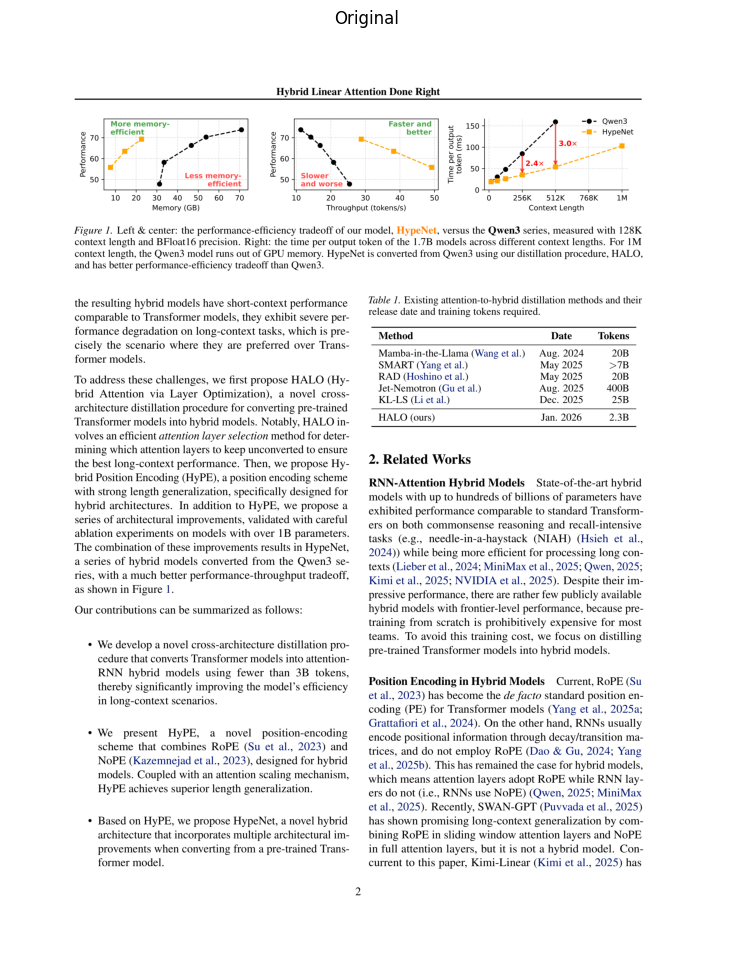

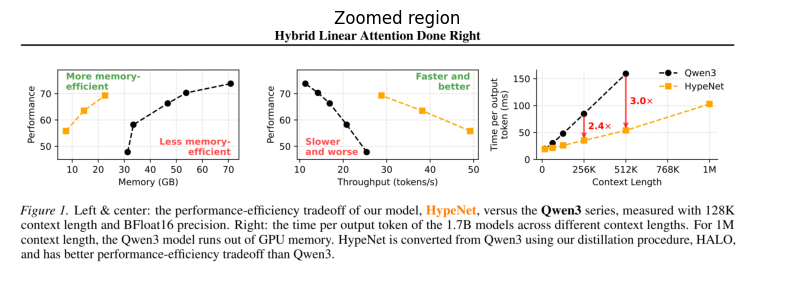

In [4]:
# Example usage
DEFAULT_IMAGE = DATA_DIR / "page_2.png"
show(DEFAULT_IMAGE, "Original")
show(crop(DEFAULT_IMAGE, 200, 200, 2400, 900), "Zoomed region")

#### Set paddleOCR

In [5]:
ocr = PaddleOCR(lang='en')

C:\Users\manel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\offici

In [7]:
result = ocr.predict('c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_2.png')

In [ ]:
page = result[0]
texts = page['rec_texts'] # recognized text strings
scores = page['rec_scores'] # confidence scores for each text line
boxes  = page['rec_polys'] #  bounding box coordinates

for text, score, box in zip(texts, scores, boxes):
    # box is a numpy array like [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
    coords = box.astype(int).tolist()  # convert to normal list of ints
    print(f"{text:25} | {score:.3f} | {coords}")

Hybrid Linear Attention Done Right | 0.979 | [[949, 27], [1606, 64], [1603, 118], [946, 81]]
More memory-              | 0.999 | [[301, 160], [536, 172], [535, 207], [299, 195]]
efficient                 | 0.963 | [[302, 194], [444, 201], [442, 237], [300, 230]]
Faster and                | 0.999 | [[1392, 191], [1567, 200], [1566, 235], [1390, 226]]
Qwen3                     | 1.000 | [[2209, 191], [2319, 195], [2318, 232], [2208, 228]]
Performance               | 1.000 | [[181, 204], [213, 203], [219, 406], [188, 407]]
70                        | 1.000 | [[216, 216], [269, 216], [269, 257], [216, 257]]
Performance               | 1.000 | [[930, 217], [963, 218], [958, 415], [924, 414]]
150                       | 1.000 | [[1688, 208], [1754, 208], [1754, 246], [1688, 246]]
70                        | 1.000 | [[964, 226], [1017, 231], [1013, 272], [960, 267]]
better                    | 1.000 | [[1460, 227], [1568, 233], [1566, 268], [1458, 262]]
Time per output           | 0.999 | [[1

### Extracted lines & bounding boxes (processed image)

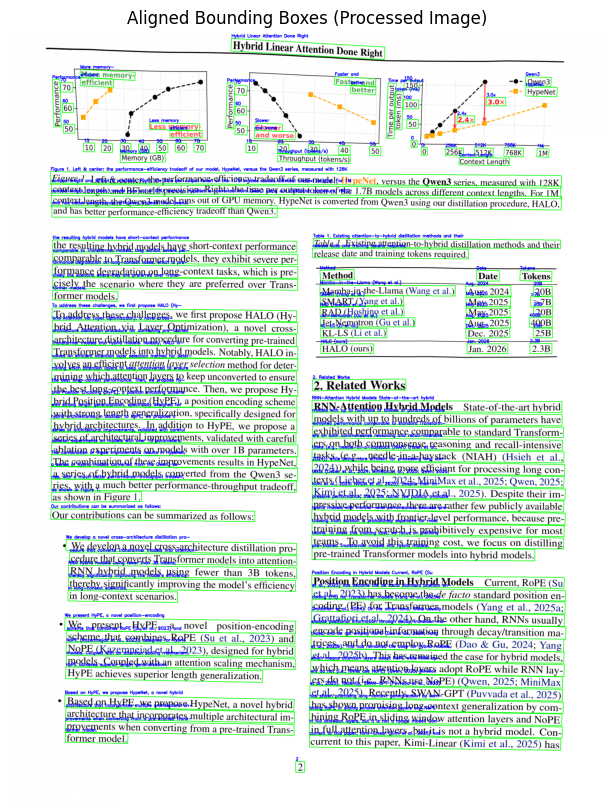

In [ ]:
img = page['doc_preprocessor_res']['output_img']
img_plot = img.copy()

for text, box in zip(texts, boxes):
    pts = np.array(box, dtype=int)
    cv2.polylines(img_plot, [pts], True, (0, 255, 0), 2)
    x, y = pts[0]
    cv2.putText(img_plot, text, (x, y - 5), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Aligned Bounding Boxes (Processed Image)")
plt.show()

### Final functions

In [ ]:
def extract_page_fields(result, page_idx=0):
    """Extract PaddleOCR page fields with basic validation."""
    if not result or page_idx >= len(result):
        raise ValueError(f"`result` is empty or page_idx={page_idx} out of range.")

    page = result[page_idx]
    required = ["rec_texts", "rec_scores", "rec_polys"]
    missing = [k for k in required if k not in page]
    if missing:
        raise KeyError(f"Missing keys in page dict: {missing}")

    texts  = page["rec_texts"]
    scores = page["rec_scores"]
    boxes  = page["rec_polys"]

    if not (len(texts) == len(scores) == len(boxes)):
        raise ValueError(
            f"Length mismatch: texts={len(texts)}, scores={len(scores)}, boxes={len(boxes)}"
        )

    # Image (optional)
    img = None
    try:
        img = page["doc_preprocessor_res"]["output_img"]
    except Exception:
        pass

    return page, texts, scores, boxes, img


def print_ocr_lines(texts, scores, boxes, min_score=0.0, top_k=None, text_width=40):
    """Pretty-print OCR results as a table-like output."""
    rows = []
    for t, s, b in zip(texts, scores, boxes):
        if s < min_score:
            continue
        coords = np.asarray(b).astype(int).tolist()
        rows.append((t, float(s), coords))

    # Sort by confidence (descending) if you want a "study" feel
    rows.sort(key=lambda x: x[1], reverse=True)

    if top_k is not None:
        rows = rows[:top_k]

    # Header
    print(f"{'text':{text_width}} | {'conf':>6} | box")
    print("-" * (text_width + 3 + 6 + 3 + 30))

    # Rows
    for t, s, coords in rows:
        t_fmt = (t[: text_width - 1] + "…") if len(t) > text_width else t
        print(f"{t_fmt:{text_width}} | {s:6.3f} | {coords}")


def draw_ocr_boxes(img, texts, boxes, scores=None, min_score=0.0,
                   box_thickness=2, font_scale=0.6):
    """
    Draw polygons + labels on a copy of img.
    If scores is given, filters by min_score.
    """
    if img is None:
        raise ValueError("No image available to draw on (img is None).")

    img_plot = img.copy()

    for i, (t, b) in enumerate(zip(texts, boxes)):
        s = scores[i] if scores is not None else 1.0
        if s < min_score:
            continue

        pts = np.asarray(b, dtype=int)

        # Draw polygon
        cv2.polylines(img_plot, [pts], isClosed=True, color=(0, 255, 0), thickness=box_thickness)

        x, y = int(pts[0][0]), int(pts[0][1])
        label = f"{t}"
        if scores is not None:
            label = f"{t} ({s:.2f})"

        cv2.putText(
            img_plot, label,
            (x, max(0, y - 6)),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale, (255, 0, 0), 2, cv2.LINE_AA
        )

    return img_plot
    
def show_image(img, title=None, figsize=(10, 12)):

    img_show = img
    if img.ndim == 3 and img.shape[2] == 3:
        img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=figsize)
    plt.imshow(img_show)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

### EXECUTIONS

In [13]:
def run_paddle (image_path):
    result = ocr.predict(image_path)
    page, texts, scores, boxes, img = extract_page_fields(result, page_idx=0)
    print_ocr_lines(texts, scores, boxes, min_score=0.50, top_k=50, text_width=45)
    if img is not None:
        img_annot = draw_ocr_boxes(img, texts, boxes, scores=scores, min_score=0.50)
        show_image(img_annot, title="Aligned Bounding Boxes (Processed Image)")
    else:
        print("No preprocessed image found at page['doc_preprocessor_res']['output_img'].")

In [14]:
PATH1 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_1.png'
PATH2 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_2.png'
PATH3 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_3.png'
PATH4 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_7.png'
PATH5 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/TFG1.png'

## Execution 1 — Simple text-only page

**Document characteristics**
- Single paper page
- Text-only content
- No charts, tables or complex layouts
- Standard academic-style formatting

**Objective**
Evaluate baseline OCR performance on a clean document page without structural complexity.

text                                          |   conf | box
---------------------------------------------------------------------------------------
Abstract                                      |  1.000 | [[548, 919], [762, 916], [763, 965], [548, 968]]
1                                             |  1.000 | [[1220, 3167], [1252, 3167], [1252, 3211], [1220, 3211]]
NVIDIA et al., 2025).                         |  1.000 | [[1280, 1840], [1699, 1842], [1699, 1890], [1280, 1888]]
long-context performance, which is the scena… |  1.000 | [[183, 1831], [1115, 1827], [1116, 1878], [183, 1882]]
1. Introduction                               |  1.000 | [[1281, 916], [1645, 919], [1644, 968], [1281, 965]]
1NLP Group, DCST, IAI, BNRIST, Tsinghua Univ… |  0.999 | [[431, 631], [1782, 631], [1782, 685], [431, 685]]
trast, recurrent neural networks (RNNs) such… |  0.999 | [[1280, 1238], [2372, 1247], [2371, 1291], [1280, 1282]]
ever, these transfer methods require substan… |  0.999 | [[186, 1671], [1

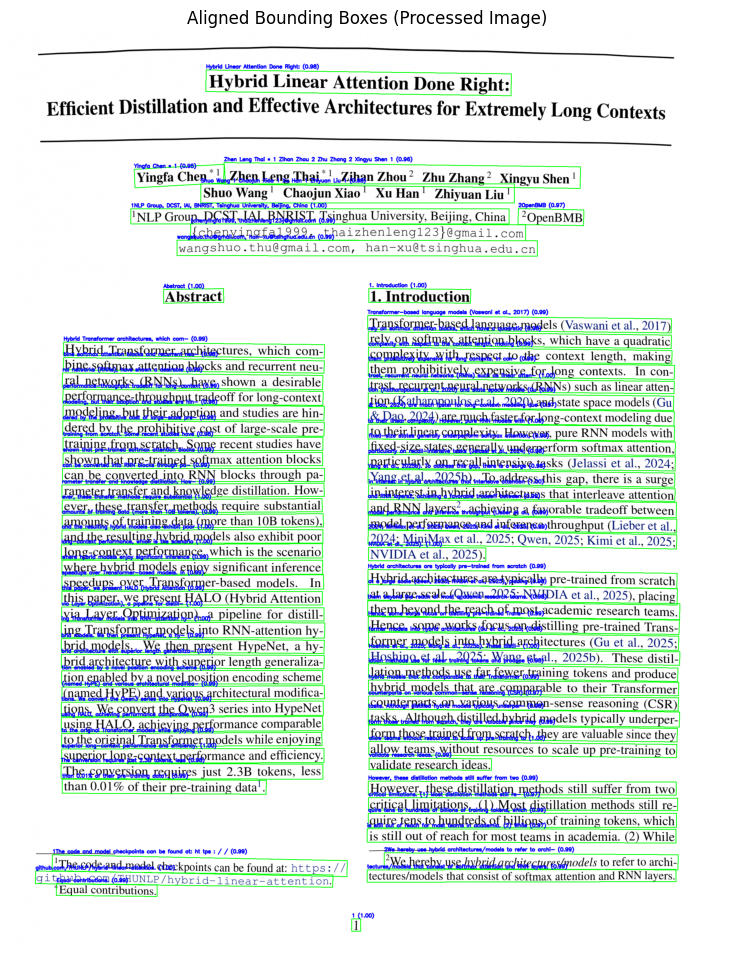

In [15]:
run_paddle('c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_1.png')

### Observations

- Recovers **most of the document text** correctly (titles, authors, body paragraphs)
- **Second title is not detected**, likely due to layout or stylistic differences.
- Remaining section titles and paragraphs are **mostly accurate**.
- Suitable for **readability**, but limited for **layout-aware analysis**.

### Execution2

text                                          |   conf | box
---------------------------------------------------------------------------------------
256K                                          |  1.000 | [[1865, 497], [1943, 497], [1943, 530], [1865, 530]]
150                                           |  1.000 | [[1688, 208], [1754, 208], [1754, 246], [1688, 246]]
512K                                          |  1.000 | [[1991, 495], [2071, 498], [2070, 534], [1990, 531]]
100                                           |  1.000 | [[1685, 291], [1751, 291], [1751, 329], [1685, 329]]
70                                            |  1.000 | [[788, 477], [837, 477], [837, 514], [788, 514]]
HypeNet                                       |  1.000 | [[2211, 235], [2345, 237], [2344, 277], [2210, 274]]
Method                                        |  1.000 | [[1328, 1021], [1474, 1017], [1476, 1060], [1330, 1064]]
768K                                          |  1.000 | [[2118, 495], [2200, 498

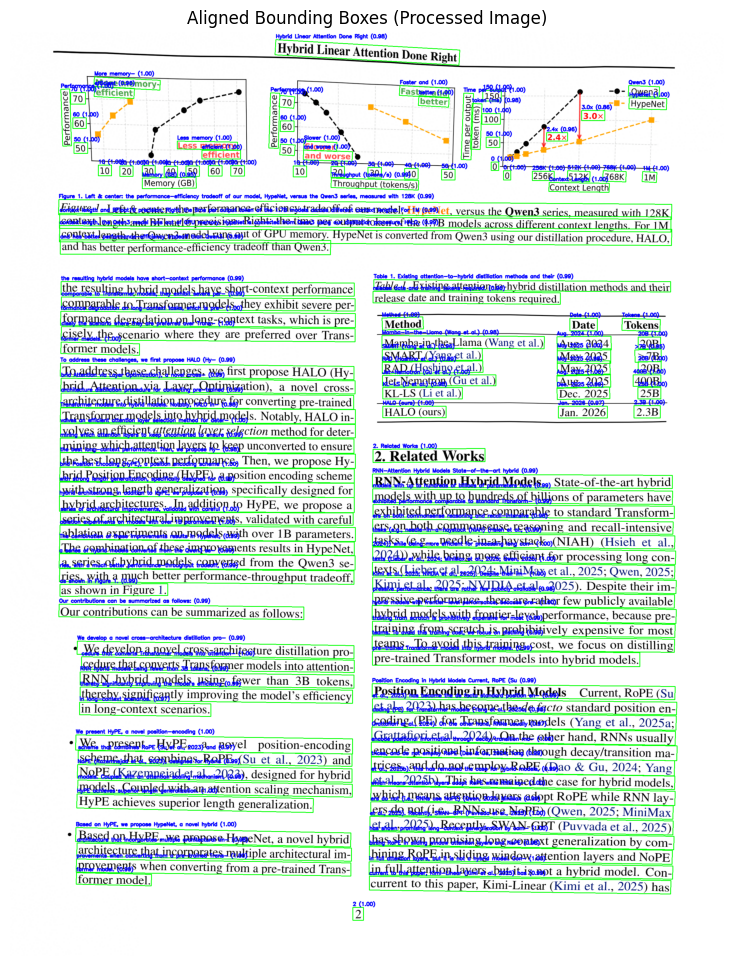

In [16]:
run_paddle('c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_2.png')

### Observations
- Correctly detects **most text regions** with accurate bounding boxes.
- **Titles, paragraphs, and references** are well localized.
- **No charts or tables are detected** as structured elements.
- Graphical elements are treated as **background or ignored**.
- OCR focuses on **text detection only**, without semantic layout understanding.
- Reading order is **not guaranteed** and must be reconstructed from geometry..


### Execution3

text                                          |   conf | box
---------------------------------------------------------------------------------------
length generalization.                        |  1.000 | [[193, 1986], [585, 1975], [586, 2020], [194, 2031]]
otherwise.                                    |  1.000 | [[820, 3122], [1012, 3115], [1014, 3164], [822, 3171]]
3                                             |  1.000 | [[1240, 3222], [1277, 3220], [1281, 3271], [1243, 3274]]
Modeling and Length Generalization            |  1.000 | [[1386, 2539], [2103, 2533], [2104, 2583], [1387, 2589]]
(4)                                           |  1.000 | [[2301, 944], [2369, 944], [2369, 1000], [2301, 1000]]
(6)                                           |  1.000 | [[2306, 1093], [2373, 1093], [2373, 1148], [2306, 1148]]
Distilling Transformers into Hybrid Models M… |  1.000 | [[187, 476], [1241, 466], [1241, 527], [188, 537]]
distribution shift when replacing an attenti… |  0.999 | [[192, 113

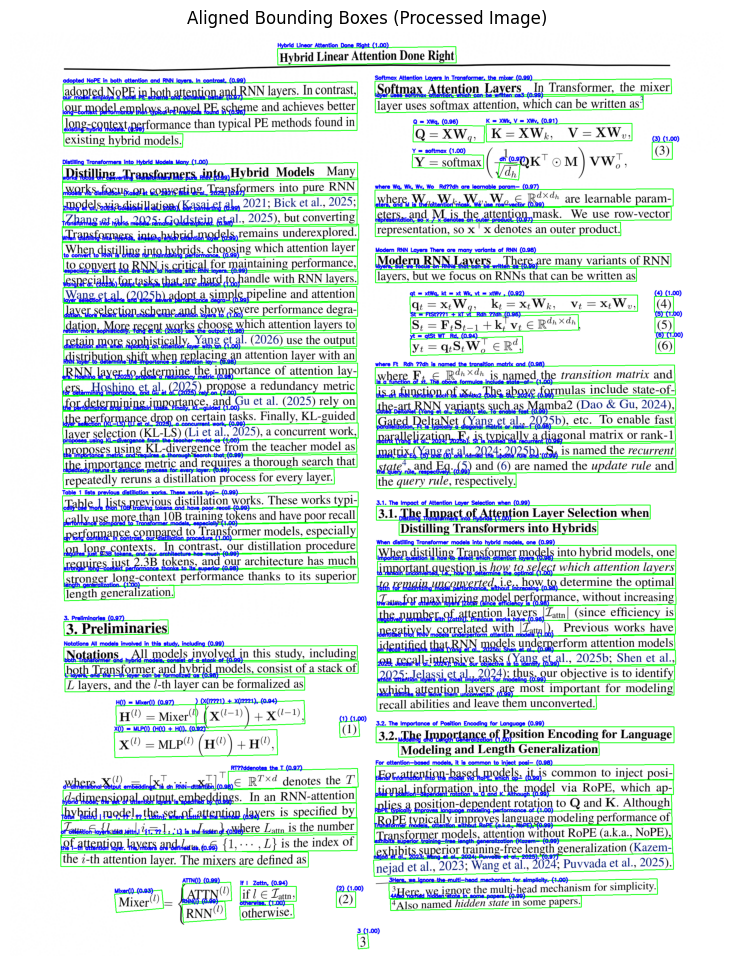

In [17]:
run_paddle('c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_3.png')

### Observations

- Mathematical formulas are **partially detected as text regions**.
- Formula layout and symbols are **not correctly reconstructed**.
- Visual structure of equations is **not preserved**.
- PaddleOCR treats formulas as **generic text**, not as structured math.


# Layaout Detection with PaddleOCR

While PaddleOCR does not directly detect charts or tables in a structured form suitable for feeding into an LLM, it provides highly valuable layout detection by accurately localizing text regions and preserving their spatial arrangement within the document.


In [2]:
from paddleocr import LayoutDetection
layout_engine = LayoutDetection()

C:\Users\manel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Checking connectivity to the model hosters, this may take a while. To bypass this check, set `PADDLE_PDX_DISABLE_MODEL_SOURCE_CHECK` to `True`.
C:\Users\manel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Using official model (PP-DocLayout_plus-L), the model files will be automatically download

This functions detects de layout regions and shows them in the pdf.

In [ ]:
def extract_layout_regions(
    image_path,
    layout_engine,
    min_confidence=0.0,
    sort_by="confidence"  # "confidence" | "top_to_bottom"
):
    """
    Run layout detection and return structured layout regions.

    Parameters
    ----------
    image_path : str or Path
        Path to input image.
    layout_engine : object
        PaddleOCR layout engine (already initialized).
    min_confidence : float
        Minimum confidence threshold.
    sort_by : str
        Sorting strategy:
        - "confidence": descending confidence
        - "top_to_bottom": reading-order-like (y, then x)

    Returns
    -------
    List[dict]
        Each dict contains: label, score, bbox, cx, cy
    """
    image_path = Path(image_path)
    if not image_path.exists():
        raise FileNotFoundError(f"Image not found: {image_path}")

    layout_result = layout_engine.predict(str(image_path))

    if not layout_result or "boxes" not in layout_result[0]:
        raise ValueError("Invalid layout detection output.")

    regions = []
    for box in layout_result[0]["boxes"]:
        score = float(box["score"])
        if score < min_confidence:
            continue

        x1, y1, x2, y2 = box["coordinate"]
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2

        regions.append({
            "label": box["label"],
            "score": score,
            "bbox": [x1, y1, x2, y2],
            "cx": cx,
            "cy": cy
        })

    if sort_by == "confidence":
        regions.sort(key=lambda r: r["score"], reverse=True)
    elif sort_by == "top_to_bottom":
        regions.sort(key=lambda r: (r["cy"], r["cx"]))
    else:
        raise ValueError(f"Unknown sort_by='{sort_by}'")

    return regions

def visualize_layout_regions(
    image_path,
    regions,
    figsize=(10, 12),
    show_labels=True,
    line_thickness=2,
    font_scale=0.6
):
    """
    Visualize layout regions on the image.

    Parameters
    ----------
    image_path : str or Path
        Path to input image.
    regions : List[dict]
        Output from extract_layout_regions.
    """
    image_path = Path(image_path)
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"cv2.imread failed for {image_path}")

    img_plot = img.copy()

    labels = sorted(set(r["label"] for r in regions))
    cmap = colormaps.get_cmap("tab20")

    color_map = {
        label: (
            int(cmap(i)[2] * 255),
            int(cmap(i)[1] * 255),
            int(cmap(i)[0] * 255),
        )
        for i, label in enumerate(labels)
    }

    for r in regions:
        x1, y1, x2, y2 = map(int, r["bbox"])
        color = color_map[r["label"]]

        pts = np.array(
            [[x1, y1], [x2, y1], [x2, y2], [x1, y2]],
            dtype=int
        )

        cv2.polylines(img_plot, [pts], True, color, line_thickness)

        if show_labels:
            text = f"{r['label']} ({r['score']:.2f})"
            cv2.putText(
                img_plot,
                text,
                (x1, max(0, y1 - 8)),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale,
                color,
                2,
                cv2.LINE_AA
            )

    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Layout Detection (PaddleOCR)")
    plt.show()

    return img_plot



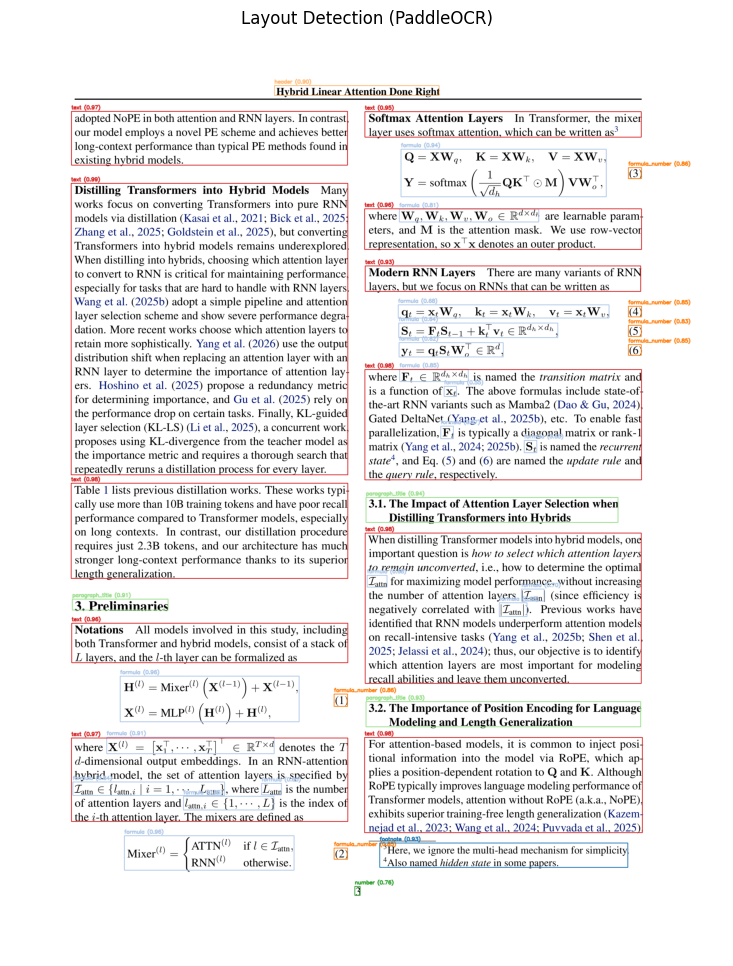

array([[[255, ..., 255],
        ...,
        [255, ..., 255]],

       ...,

       [[255, ..., 255],
        ...,
        [255, ..., 255]]], dtype=uint8)

In [10]:
regions = extract_layout_regions(
    image_path="c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_3.png",
    layout_engine=layout_engine,
    min_confidence=0.5,
    sort_by="top_to_bottom"
)

visualize_layout_regions(
    image_path="c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_3.png",
    regions=regions
)


In [ ]:
def visualize_layout(image_path, min_confidence=0.5):
    
    layout_result = layout_engine.predict(image_path)
    
    img = cv2.imread(image_path)
    img_plot = img.copy()
    
    # Get all unique labels
    labels = list(set(box['label'] for box in layout_result[0]['boxes']))
    
    # Generate colors dynamically from colormap
    cmap = colormaps.get_cmap('tab20') 
    color_map = {}
    for i, label in enumerate(labels):
        rgba = cmap(i % 20)
        # Convert to BGR (0-255) for OpenCV
        color_map[label] = (int(rgba[2]*255), int(rgba[1]*255), int(rgba[0]*255))
    
    for box in layout_result[0]['boxes']:
        if box['score'] < min_confidence:
            continue
            
        label = box['label']
        score = box['score']
        coords = box['coordinate']
        
        color = color_map[label]
        
        x1, y1, x2, y2 = [int(c) for c in coords]
        pts = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=int)
        
        cv2.polylines(img_plot, [pts], True, color, 2)
        text = f"{label} ({score:.2f})"
        cv2.putText(img_plot, text, (x1, y1-8), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    return img_plot

In [ ]:
# Run visualization
result_image = visualize_layout("article.jpg", min_confidence=0.5)

# Display with matplotlib
plt.figure(figsize=(12, 14))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Layout Detection Results")
plt.show()